### Vision: A Digital Twin for the Stockholm Archipelago Trail (SAT)
* Issue [#202](https://github.com/salgo60/Stockholm_Archipelago_Trail/issues/202)
* this [notebook](https://github.com/salgo60/Stockholm_Archipelago_Trail/tree/main/notebook/SAT202_Digital_twin.ipynb)

In [1]:
import time

from datetime import datetime

now = datetime.now()
timestamp = now.timestamp()

start_time = time.time()
print("Start:", datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

Start: 2025-09-28 22:33:18


In [2]:
import os

current_dir = os.getcwd()
print(current_dir)

/Users/salgo/Documents/GitHub/Stockholm_Archipelago_Trail/notebook


/var/folders/fd/md6r13sj0wsbg_6_xl160d300000gn/T/ipykernel_71371/4239826393.py:37: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buffer200_union = buffer200.unary_union


✅ Trail prepared with 790 line parts and 200m buffer
📡 Fetching Toilets …
✅ Toilets: 83 found
📡 Fetching Drinking water …
✅ Drinking water: 48 found
📡 Fetching Restaurants …
✅ Restaurants: 19 found
📡 Fetching Pubs …
✅ Pubs: 0 found
📡 Fetching Grocery …
✅ Grocery: 2 found
📡 Fetching Churches …
✅ Churches: 0 found
📡 Fetching Cemeteries …
✅ Cemeteries: 0 found
           Toilets  Drinking water  Restaurants  Pubs  Grocery  Churches  \
SAT Trail       83              48           19     0        2         0   

           Cemeteries  
SAT Trail           0  


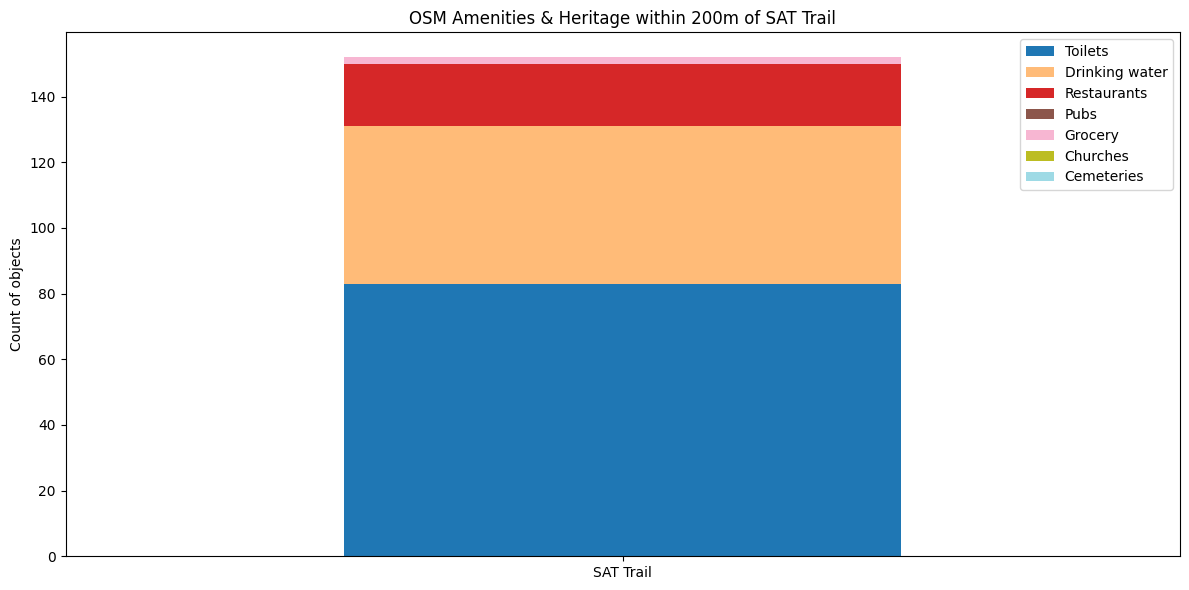

In [25]:
import os
import time
import requests
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point, LineString, Polygon, MultiLineString
from shapely.ops import unary_union
import matplotlib.pyplot as plt

# ------------------------
# 1. Trail preparation
# ------------------------
geojson_path = "SAT_full.geojson"

gdf_sat = gpd.read_file(geojson_path)
if gdf_sat.crs is None:
    gdf_sat = gdf_sat.set_crs("EPSG:4326", allow_override=True)
else:
    gdf_sat = gdf_sat.to_crs("EPSG:4326")

# Keep only lines
gdf_lines = gdf_sat[gdf_sat.geometry.geom_type.isin(["LineString", "MultiLineString"])].copy()
trail_parts = gdf_lines.explode(index_parts=False, ignore_index=True)
gdf_trail = trail_parts[["geometry"]].copy().set_crs("EPSG:4326")

# Merge all into MultiLineString for nearest join later
multi = MultiLineString([ls for ls in trail_parts.geometry.values])
meta_gdf = gpd.GeoDataFrame(
    [{"label": "Stockholm Archipelago Trail", "geometry": multi}],
    crs="EPSG:4326"
)

# Buffer 200m
trail_utm = gdf_trail.to_crs(3006)
buffer200_utm = trail_utm.buffer(200)
buffer200 = buffer200_utm.to_crs(4326)
buffer200_union = buffer200.union_all()

print(f"✅ Trail prepared with {len(gdf_trail)} line parts and 200m buffer")

# ------------------------
# 2. Overpass helpers
# ------------------------
overpass_endpoints = [
    "https://overpass-api.de/api/interpreter",
    "https://z.overpass-api.de/api/interpreter",
    "https://overpass.kumi.systems/api/interpreter",
]

HEADERS = {"User-Agent": "SAT-map/1.0 (contact: your-email@example.com)"}

def frange(start, stop, step):
    vals, cur = [], start
    while cur < stop - 1e-9:
        vals.append(cur)
        cur += step
    return vals

def bbox_to_tiles(bbox, max_deg=0.25):
    minx, miny, maxx, maxy = bbox
    xs = list(frange(minx, maxx, max_deg))
    ys = list(frange(miny, maxy, max_deg))
    tiles = []
    for x1 in xs:
        x2 = min(x1 + max_deg, maxx)
        for y1 in ys:
            y2 = min(y1 + max_deg, maxy)
            tiles.append((x1, y1, x2, y2))
    return tiles

def overpass_fetch(query, timeout=120, retries=3, backoff=2.0):
    last_err = None
    for ep in overpass_endpoints:
        for attempt in range(1, retries+1):
            try:
                r = requests.post(ep, data={"data": query}, headers=HEADERS, timeout=timeout)
                if r.status_code == 200:
                    return r.json()
                time.sleep(backoff * attempt)
            except Exception as e:
                last_err = e
                time.sleep(backoff * attempt)
    raise RuntimeError(f"Overpass failed on all mirrors. Last error: {last_err}")

def parse_elements_to_points(elements):
    rows = []
    for el in elements:
        t = el.get("type")
        tags = el.get("tags", {}) or {}
        el_id = el.get("id")

        if t == "node" and "lat" in el and "lon" in el:
            pt = Point(el["lon"], el["lat"])
            rows.append({"geometry": pt, "tags": tags, "id": el_id, "elem_type": t})
        elif t in ("way", "relation"):
            c = el.get("center")
            if c and "lat" in c and "lon" in c:
                pt = Point(c["lon"], c["lat"])
                rows.append({"geometry": pt, "tags": tags, "id": el_id, "elem_type": t})
    return rows

def build_query(overpass_bbox, key, value):
    return f"""
[out:json][timeout:90];
(
  node["{key}"="{value}"]{overpass_bbox};
  way["{key}"="{value}"]{overpass_bbox};
  relation["{key}"="{value}"]{overpass_bbox};
);
out center tags bb;
"""

# ------------------------
# 3. General fetch function
# ------------------------
def fetch_osm_points_near_trail(gdf_trail, buffer_union, key, value, buffer_m=200):
    bbox = gdf_trail.total_bounds
    tiles = bbox_to_tiles(bbox, max_deg=0.25)

    rows = []
    for (minx, miny, maxx, maxy) in tiles:
        overpass_bbox = f"({miny},{minx},{maxy},{maxx})"
        q = build_query(overpass_bbox, key, value)
        try:
            data = overpass_fetch(q, timeout=120, retries=3, backoff=2.0)
            els = data.get("elements", [])
            rows.extend(parse_elements_to_points(els))
        except Exception as e:
            print(f"⚠️ Tile {minx:.2f},{miny:.2f} fetch failed: {e}")

    gdf = gpd.GeoDataFrame(rows, crs="EPSG:4326")
    if not gdf.empty:
        gdf = gdf[gdf.intersects(buffer_union)]
    return gdf

# ------------------------
# 4. Run for multiple categories
# ------------------------
categories = {
    "Toilets": ("amenity", "toilets"),
    "Drinking water": ("amenity", "drinking_water"),
    "Restaurants": ("amenity", "restaurant"),
    "Pubs": ("amenity", "pub"),
    "Grocery": ("shop", "supermarket"),
    "Churches": ("amenity", "place_of_worship"),
    "Cemeteries": ("landuse", "cemetery"),
}

results = {}
for cat, (key, value) in categories.items():
    print(f"📡 Fetching {cat} …")
    gdf = fetch_osm_points_near_trail(gdf_trail, buffer200_union, key, value, buffer_m=200)
    results[cat] = gdf
    print(f"✅ {cat}: {len(gdf)} found")

# ------------------------
# 5. Aggregate counts per category
# ------------------------
summary = {cat: len(gdf) for cat, gdf in results.items()}
df_summary = pd.DataFrame([summary], index=["SAT Trail"])
print(df_summary)

# ------------------------
# 6. Plot stacked bar chart
# ------------------------
df_summary.plot(kind="bar", stacked=True, figsize=(12,6), colormap="tab20")

plt.title("OSM Amenities & Heritage within 200m of SAT Trail")
plt.ylabel("Count of objects")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [40]:
import geopandas as gpd
import pandas as pd
import requests
import time
from shapely.geometry import Point
import matplotlib.pyplot as plt

# ------------------------
# 1. Trail prep (same as before)
# ------------------------
geojson_path = "SAT_full.geojson"

gdf_sat = gpd.read_file(geojson_path).to_crs("EPSG:4326")
gdf_lines = gdf_sat[gdf_sat.geometry.geom_type.isin(["LineString", "MultiLineString"])].copy()
trail_parts = gdf_lines.explode(index_parts=False, ignore_index=True)
gdf_trail = trail_parts[["geometry"]].copy().set_crs("EPSG:4326")

# Section labels
if "Labelen" in gdf_sat.columns:
    labels = gdf_sat["Labelen"].tolist()
else:
    labels = [f"Etapp {i+1}" for i in range(len(gdf_trail))]
gdf_trail["Section"] = labels[:len(gdf_trail)]

# Buffers
trail_utm = gdf_trail.to_crs(3006)
gdf_trail["buffer200"] = trail_utm.buffer(200).to_crs(4326)

# ------------------------
# 2. Overpass helpers
# ------------------------
overpass_endpoints = [
    "https://overpass-api.de/api/interpreter",
    "https://z.overpass-api.de/api/interpreter",
    "https://overpass.kumi.systems/api/interpreter",
]
HEADERS = {"User-Agent": "SAT-map/1.0 (contact: your-email@example.com)"}

def overpass_fetch(query, timeout=120, retries=3, backoff=2.0):
    last_err = None
    for ep in overpass_endpoints:
        for attempt in range(1, retries+1):
            try:
                r = requests.post(ep, data={"data": query}, headers=HEADERS, timeout=timeout)
                if r.status_code == 200:
                    return r.json()
                time.sleep(backoff * attempt)
            except Exception as e:
                last_err = e
                time.sleep(backoff * attempt)
    raise RuntimeError(f"Overpass failed: {last_err}")

def build_query(bbox, key, value):
    return f"""
[out:json][timeout:90];
(
  node["{key}"="{value}"]{bbox};
  way["{key}"="{value}"]{bbox};
  relation["{key}"="{value}"]{bbox};
);
out center tags bb;
"""

def parse_elements(elements):
    rows = []
    for el in elements:
        t = el.get("type")
        tags = el.get("tags", {}) or {}
        el_id = el.get("id")
        if t == "node" and "lat" in el and "lon" in el:
            rows.append({"geometry": Point(el["lon"], el["lat"]), "tags": tags, "id": el_id})
        elif t in ("way", "relation") and "center" in el:
            c = el["center"]
            rows.append({"geometry": Point(c["lon"], c["lat"]), "tags": tags, "id": el_id})
    return rows

def fetch_category(gdf_trail, key, value):
    minx, miny, maxx, maxy = gdf_trail.total_bounds
    bbox = f"({miny},{minx},{maxy},{maxx})"
    query = build_query(bbox, key, value)
    data = overpass_fetch(query)
    els = data.get("elements", [])
    return gpd.GeoDataFrame(parse_elements(els), crs="EPSG:4326")

# ------------------------
# 3. Categories
# ------------------------
categories = {
    "Toilets": ("amenity", "toilets"),
    "Drinking water": ("amenity", "drinking_water"),
    "Restaurants": ("amenity", "restaurant"),
    "Pubs": ("amenity", "pub"),
    "Grocery": ("shop", "supermarket"),
    "Churches": ("amenity", "place_of_worship"),
    "Cemeteries": ("landuse", "cemetery"),
}

# ------------------------
# 4. Count per section (all + wheelchair breakdown)
# ------------------------
results = []
for cat, (key, value) in categories.items():
    print(f"📡 Fetching {cat} …")
    gdf_cat = fetch_category(gdf_trail, key, value)
    if gdf_cat.empty:
        continue

    for idx, row in gdf_trail.iterrows():
        buf = row["buffer200"]

        # Objects in buffer
        subset = gdf_cat[gdf_cat.intersects(buf)]

        # Initialize counts
        count_all = len(subset)
        wc_counts = {"yes": 0, "no": 0, "limited": 0, "missing": 0}

        for _, r in subset.iterrows():
            tags = r.get("tags", {})
            val = (tags.get("wheelchair") or "").lower()
            if val in wc_counts:
                wc_counts[val] += 1
            else:
                wc_counts["missing"] += 1

        results.append({
            "Section": row["Section"],
            "Category": cat,
            "All": count_all,
            "yes": wc_counts["yes"],
            "no": wc_counts["no"],
            "limited": wc_counts["limited"],
            "missing": wc_counts["missing"]
        })

df = pd.DataFrame(results)

# Pivot
df_all = df.pivot_table(
    index="Section",
    columns="Category",
    values="All",
    aggfunc="sum",
    fill_value=0
).astype(int)

#df_wheel = df.pivot_table(
#    index="Section",
#    columns="Category",
#    values="Wheelchair",
#    aggfunc="sum",
#    fill_value=0
#).astype(int)

print("All objects:")
print(df_all.head())

print("\nWheelchair=yes objects:")
print(df_wheel.head())

# Aggregate by Section+Category
df_agg = (
    df.groupby(["Section", "Category"], as_index=False)[["yes", "no", "limited", "missing"]]
      .sum()
)

# ---- Option A: Long format (best for flexible plotting) ----
df_long = df_agg.melt(
    id_vars=["Section", "Category"],
    value_vars=["yes", "no", "limited", "missing"],
    var_name="Wheelchair",
    value_name="Count"
)

print("Long format (first rows):")
print(df_long.head())



# After building df = pd.DataFrame(results)

# Aggregate by Section+Category
df_agg = df.groupby(["Section", "Category"], as_index=False)[["yes","no","limited","missing"]].sum()

dupes = df[df.duplicated(subset=["Section", "Category"], keep=False)]
print(dupes.sort_values(["Section", "Category"])) 
df = df.drop_duplicates(subset=["Section", "Category"])
# Pivot per wheelchair status
df_yes = df_agg.pivot(index="Section", columns="Category", values="yes").fillna(0).astype(int)
df_no = df_agg.pivot(index="Section", columns="Category", values="no").fillna(0).astype(int)
df_lim = df_agg.pivot(index="Section", columns="Category", values="limited").fillna(0).astype(int)
df_miss = df_agg.pivot(index="Section", columns="Category", values="missing").fillna(0).astype(int)

print("✅ Example wheelchair counts (yes):")
print(df_yes.head())


# ------------------------
# 5. Visualisation (stacked by wheelchair status)
# ------------------------

# Long format is best for plotting stacked bars
#df_long = df.melt(
#    id_vars=["Section", "Category"],
#    value_vars=["yes", "no", "limited", "missing"],
#    var_name="Wheelchair",
#    value_name="Count"
#)

# Example: aggregate over all categories, grouped by Section + Wheelchair
df_sec_wc = df_long.groupby(["Section", "Wheelchair"], as_index=False)["Count"].sum()

# Pivot back wide so each status is a column
#df_wide = df_sec_wc.pivot(
#    index="Section",
#    columns="Wheelchair",
#    values="Count"
#).fillna(0).astype(int)

# Plot stacked bar (per section, split by wheelchair status)
#fig, ax = plt.subplots(figsize=(14, 6))
#df_wide.plot(kind="bar", stacked=True, ax=ax, colormap="tab20c")

ax.set_title("OSM amenities within 200m of SAT sections — Wheelchair accessibility")
ax.set_ylabel("Count")
plt.xticks(rotation=60, ha="right")
plt.tight_layout()
plt.show()


# ------------------------
# 6. Alternative: split by category too (multi-level)
# ------------------------

df_sec_cat_wc = df_long.pivot_table(
    index=["Section", "Category"],
    columns="Wheelchair",
    values="Count",
    aggfunc="sum",
    fill_value=0
)

print("\n✅ Section × Category × Wheelchair counts:")
print(df_sec_cat_wc.head())


📡 Fetching Toilets …
📡 Fetching Drinking water …
📡 Fetching Restaurants …
📡 Fetching Pubs …
📡 Fetching Grocery …
📡 Fetching Churches …
📡 Fetching Cemeteries …
All objects:
Category       Cemeteries  Churches  Drinking water  Grocery  Pubs  \
Section                                                              
SAT Arholma             0         0              14        0     0   
SAT Brottö              0         0               0        0     0   
SAT Finnhamn            0         0              64        0     0   
SAT Fjärdlång           0         0               6        0     0   
SAT Furusund            0         0               0        0     0   

Category       Restaurants  Toilets  
Section                              
SAT Arholma             15       22  
SAT Brottö               0        0  
SAT Finnhamn             1       75  
SAT Fjärdlång            0       41  
SAT Furusund            10       12  

Wheelchair=yes objects:
Category       Cemeteries  Churches  Drinking 

NameError: name 'ax' is not defined

In [2]:
 # End timer and calculate duration
end_time = time.time()
elapsed_time = end_time - start_time# Bygg audit-lager för den här etappen

# Print current date and total time
print("Date:", datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
minutes, seconds = divmod(elapsed_time, 60)
print("Total time elapsed: {:02.0f} minutes {:05.2f} seconds".format(minutes, seconds))


Date: 2025-09-28 22:22:46
Total time elapsed: 00 minutes 15.63 seconds
